<a href="https://colab.research.google.com/github/nataliarestrada/IPDI-Estrada/blob/main/PDI_TP6_Estrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Practico N°6 - Segmentación
Asignatura: **Introducción al Procesamiento Digital de Imágenes (PDI)**

Alumno: **Natalia R. Estrada** - email: nataliarominaestrada@gmail.com

**Actividad práctica:**
1. Dadas imágenes a niveles de gris, binarizarlas y comparar los resultados:
 * El resultado final tiene 50% de pixels negros y blancos.
 * Encontrar dos modas “clara” y “oscura” y binarizar por distancia mínima.
 * Binarización de Otsu.
2. En imágenes como la (a) encontrar los bordes aplicando Laplaciano, borde
morfológico, marching squares.

###Desarrollo
####Importamos las librerias necesarias

In [1]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
from google.colab import files
import scipy.stats as stats
import random
import collections
from functools import reduce
from random import randint
from math import inf

####Funciones necesarias para realizar las operaciones

In [2]:
#Función para convertir una imagen del espacio RGB al YIQ
def rgb_to_yiq(RGB):
    '''
    input: matriz de la imagen en formato RGB normalizada
    output: matriz de la imagen en formato YIQ
    '''
    rgb2yiq_matrix = np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
    #print("Matriz de conversion RGB a YIQ:")
    #print(rgb2yiq_matrix)

    #Se normalizan los valores de RGB entre 0.0 y 1.0
    RGB = RGB/255 

    Y = rgb2yiq_matrix[0][0] * RGB[:,:,0] + rgb2yiq_matrix[0][1] * RGB[:,:,1] + rgb2yiq_matrix[0][2] * RGB[:,:,2]
    I = rgb2yiq_matrix[1][0] * RGB[:,:,0] + rgb2yiq_matrix[1][1] * RGB[:,:,1] + rgb2yiq_matrix[1][2] * RGB[:,:,2]
    Q = rgb2yiq_matrix[2][0] * RGB[:,:,0] + rgb2yiq_matrix[2][1] * RGB[:,:,1] + rgb2yiq_matrix[2][2] * RGB[:,:,2]

    Y = np.clip(Y, 0, 1)
    I = np.clip(I, -0.5957, 0.5957)
    Q = np.clip(Q, -0.5226, 0.5226)
    
    YIQ = np.dstack((Y,I,Q))
    
    return YIQ

#Función para plotear una imagen
def plot_image(image, title, figsize=(10,6)):
    fig, axs = plt.subplots(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.title(title, fontsize=14)
    plt.axis('off')


#Función que realiza la binarización de los valores de cada pixel de la matriz Y
def binarizacion(yiq):
    width,height = yiq.shape
    yiq_bin = np.zeros(yiq.shape)
    umb = np.median(yiq)
    for x in range (width):
        for y in range (height):
            if yiq[x,y] > umb:
                yiq_bin[x,y] = 1
            else:
                yiq_bin[x,y] = 0
    return yiq_bin
#PUNTO 1----------------------------------------------------------------------------------
#Función para contabilizar la proporción de pixels blancos y negros luego de binarizar
def proporcion(img):
    width,height = img.shape
    black=0
    white=0
    
    for x in range (width):
        for y in range (height):
            if img[x,y]==1:
                white=white+1
            else:
                black=black+1
    return (black,white)

#Funcion para encontrar dos modas “clara” y “oscura”
def two_mode(image):
    width,height =image.shape
    px=[]
    for x in range(width):
        for y in range(height):
            px.append(image[x,y])
    a, b =collections.Counter(px).most_common(2)
    moda1=a[0]
    moda2=b[0]
    if moda1<moda2:
        dark_mode=moda2
        bright_mode=moda1
    else:
        dark_mode=moda1
        bright_mode=moda2
    return (bright_mode, dark_mode)

#Función para Binarizar por el metodo de Distancia Mínima
def dist_min (yiq,bright,dark):
    width,height = yiq.shape
    yiq_bin = np.zeros(yiq.shape)
    umb = (bright + dark)/2
    for x in range (width):
        for y in range (height):
            if yiq[x,y] > umb:
                yiq_bin[x,y] = 1
            else:
                yiq_bin[x,y] = 0
    return yiq_bin

#Funcion para Binarizar por el metodo de Otsu
def otsu(image):
    #histograma
    width, height=image.shape
    bins=100
    yiq_mod=np.reshape(image,(width*height))
    hist=np.histogram(yiq_mod, bins, range=(0,1))
    hist=hist[0]
    hist=hist/max(hist)

    pixel_numb = image.shape[0] * image.shape[1]
    prom_pond = 1/pixel_numb
    final_thresh = -1
    final_value = -1
    intensity = np.arange(100)
    for x in range (1,100):
        pcb = np.sum(hist[:x])
        pcf = np.sum(hist[x:])
        wb = pcb * prom_pond
        wf = pcf * prom_pond
        
        mub = np.sum(intensity[:x] * hist[:x]) / float(pcb)
        muf = np.sum(intensity[x:] * hist[x:]) / float(pcf)
        
        value = wb * wf * (mub-muf) **2
        if value > final_value:
            final_thresh = x/100
            final_value = value

    #print(final_thresh)
    #binarizar
    img_bin = image.copy()
    img_bin[image > final_thresh] = 1
    img_bin[image < final_thresh] = 0
    return img_bin

#PUNTO 2---------------------------------------------------------------------------
#Kernels Laplaciano
kernel_laplaciano_v8 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
kernel_laplaciano_v4 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

#Función para agregar bordes a la imagen(banda Y del espacio YIQ) para realizar la convolución. Permite realizar un 0-padding
def add_borders(Y,kernel):
    shapeY = Y.shape
    heightY = shapeY[0]
    widthY = shapeY[1]

    #Según el tamaño del kernel, el padding de ceros a realizar es
    if kernel.shape[0] == 3:
        Ypadding = np.zeros((heightY+2,widthY+2))
        Ypadding[1:heightY+1,1:widthY+1] = Y
        
    elif kernel.shape[0] == 5:
        Ypadding = np.zeros((heightY+4,widthY+4))
        Ypadding[2:heightY+2,2:widthY+2] = Y
        
    elif kernel.shape[0] == 7:
        Ypadding = np.zeros((heightY+6,widthY+6))
        Ypadding[3:heightY+3,3:widthY+3] = Y
        
    return Ypadding

#Función para realizar la convolución entre una imagen(banda Y del espacio YIQ) y un kernel
def _convolution(image_y,kernel):
 
  image_y_mod = add_borders(image_y,kernel)
  convolved= np.zeros((np.array(image_y_mod.shape)-np.array(kernel.shape)+1))
  
  for x in range(convolved.shape[0]):
      for y in range(convolved.shape[1]):
          convolved[x,y]=(image_y_mod[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).sum()

  convolved = np.clip(convolved,0.,1.)
  return convolved

#procesamiento morfologico
def erosion (yiq):
    elm=np.ones((3,3)) #creación del elemento estructurante
    he,we=elm.shape
    
    apoyoX=(he-1)//2 #defino el punto de apoyo del elemento estructurante
    apoyoY=(we-1)//2
    
    img = np.pad(yiq[:,:],[(apoyoX,apoyoX),(apoyoY,apoyoY)],'edge') #redefino los bordes según el tamaño del estructurante
        
    h,w=yiq[:,:].shape #procedimiento de erosión de la imagen
    img_eros=np.zeros(yiq[:,:].shape)
    for x in range (h):
        for y in range (w):
            n=np.nanmin(img[x:x+he,y:y+we]*elm[:,:])
            img_eros[x,y]=n
    return img_eros

def dilatacion (yiq):
    elm=np.ones((3,3)) #creación del elemento estructurante
    he,we=elm.shape
    
    apoyoX=(he-1)//2 #defino el punto de apoyo del elemento estructurante
    apoyoY=(we-1)//2
    
    img = np.pad(yiq[:,:],[(apoyoX,apoyoX),(apoyoY,apoyoY)],'edge') #redefino los bordes según el tamaño del estructurante
        
    h,w=yiq[:,:].shape #procedimiento de dilatación de la imagen
    img_dil=np.zeros(yiq[:,:].shape)
    for x in range (h):
        for y in range (w):
            n=np.nanmax(img[x:x+he,y:y+we]*elm[:,:])
            img_dil[x,y]=n
    return img_dil

#MarchingSquaresAlgoritm
class MarchingSquares(object):
    """
    An object for a marching-squares implementation.
    """

    def __init__(self, grid:list, lower_threshold:float = 0.5, upper_threshold:float = inf) -> None:
        """
        A marching square implementation that takes a 2D grid of values to form the grid around.

        Parameters
        ----------
        grid, list
            The grid of values to create marching squares from
        
        lower_threshold, float (optional)
            The lower value of values in the grid when binarizing the grid, all values below 
            this threshold will be set to zero

        upper_threshold, float (optional)
            The upper value to use when binarizing the grid. Default to zero, meaning no upper
            threshold will be set. Can be lowered to ensure only a band of values are binarized to 1.
        """

        # Only 2D grids with more than 1 value are valid - TODO: doesnt catch 3D list
        assert isinstance(grid, list) and 1 < len(grid), "'grid' was not a list with more than one element"
        assert reduce(lambda a,b : isinstance(b,list) and a, grid, True), "Not all elements in 'grid' were lists"
        assert reduce(lambda a,b : 1 < len(b) and a, grid, True), "Not all sublists had more than one element"

        self.lower_threshold = lower_threshold
        self.upper_threshold = upper_threshold

        self.h = len(grid)
        self.w = len(grid[0])
        self.N = self.w * self.h

        self.grid = grid
        self.binary_grid = self.__binarize(self.grid)
        self.cells = self.__calc_cell_values(self.binary_grid)
        

    def __binarize(self, grid: list) -> list:
        """ Binarize the grid to 0 and 1 using a threshold. Threshold defaults to 0.5. """
        g = [[0 for _ in range(self.w)] for _ in range(self.h)]

        for x, row in enumerate(grid):
            for y, cell in enumerate(row):
                g[x][y] = int(self.lower_threshold <= cell and cell <= self.upper_threshold)            
        return g


    def __calc_cell_values(self, grid: list) -> list:
        """ 
        Every 2x2 block of cells in the binary image forms a contouring cell, so the whole image is 
        represented by a grid of such cells.
        Every cell is given a number between 0 and 15 corresponding to the neighbour configuration.
        Note that this grid of cells is one cell smaller in each direction than the original 2D field.
        
        Source: https://en.wikipedia.org/wiki/Marching_squares
        """

        cells = [[0 for _ in range(self.w-1)] for _ in range(self.h-1)]

        for y in range(self.h-1):
            for x in range(self.w-1):
                # Use 1 - x to invert 0 and 1 and use as a bitmask
                cells[y][x] = 8*(1-grid[y][x]) + 4*(1-grid[y][x+1]) + 1*(1-grid[y+1][x]) + 2*(1-grid[y+1][x+1])

        return cells


    def plot_polygons(self, fill:bool = True, show_grid:bool = True, edge_color:str = 'orange', fill_color:str = 'orange', fig_size:tuple = (7,7)) -> None:
        """
        Plot the polygons of the marching squares sequence.

        Parameters
        ----------
        
        fill, bool (optional)
            Boolean indication of whether to fill the polygons
        
        show_grid, bool (optional)
            Whether to show the grid points given, defaults to true
        
        edge_color, str (optional)
            The color of the edges to draw, defaults to orange
        
        fill_color, str (optional)
            The color to fill the polygons with, defaults to orange
        
        fig_size, tuple (optional)
            The size of the figure to draw, defaults to (7,7)
        """

        h,w = self.h-1, self.w-1
        
        plt.figure(figsize=fig_size)
        plt.axes(xlim=(0, w), ylim=(0, h))

        plt.title(f"{self.w} x {self.h}", loc='left')
        plt.title("Marching Squares ", loc='center', fontweight='bold')
        
        if show_grid:
            self.__show_grid()

        for y in range(h):
            for x in range(w):
                for polygon in contour_polygons[self.cells[y][x]]:

                    points = [[x0+x, h-y-1+y0] for (x0,y0) in polygon]
                    
                    p = plt.Polygon(points, edgecolor=edge_color, facecolor=fill_color, fill=fill)
                    plt.gca().add_patch(p)
            
        plt.show()


    def plot_edges(self, show_grid:bool = True, edge_color:str = 'orange', fig_size:tuple = (7,7)) -> None:
        """ 
        Plot the outer edges of the resulting marching squares sequence 

        Parameters
        ----------
        show_grid, bool (optional)
            Whether to show the grid points given, defaults to true
        
        edge_color, str (optional)
            The color of the edges to draw, defaults to orange
        
        fig_size, tuple (optional)
            The size of the figure to draw, defaults to (7,7)
        """
        
        h,w = self.h-1, self.w-1
        
        plt.figure(figsize=fig_size)
        plt.axes(xlim=(0, w), ylim=(0, h))

        plt.title(f"{self.w} x {self.h}", loc='left')
        plt.title("Marching Squares ", loc='center', fontweight='bold')
        
        if show_grid:
            self.__show_grid()

        for y in range(h):
            for x in range(w):

                cell_val = self.cells[y][x]
                for edge in contour_edges[cell_val]:
                    plt.plot([edge[0][0]+x, edge[1][0]+x],[h+edge[0][1]-y-1, h+edge[1][1]-y-1], color=edge_color, zorder=1)
        
        plt.show()


    def plot_grid(self, point_color:str = 'black', fig_size:tuple = (7,7)) -> None:
        """ 
        Plot the grid points in a plot with a color, title and size
        
        Parameters
        ----------

        point_color, (optional)
            The color in which to plot the points, defaults to black
        
        fig_size, tuple (optional)
            The size of the figure to draw, defaults to (7,7)
        """

        h,w = self.h-1, self.w-1
        
        plt.figure(figsize=fig_size)
        plt.axes(xlim=(0, w), ylim=(0, h))

        plt.title(f"{self.w} x {self.h}", loc='left')
        plt.title("Marching Squares ", loc='center', fontweight='bold')
        
        self.__show_grid(point_color)
        plt.show()


    def __show_grid(self, color:str = 'black') -> None:
        """ Helper function to plot the individual points in the grid """

        for y in range(self.h):
            for x in range(self.w):

                if self.binary_grid[y][x]:
                    plt.plot([x],[self.h-y-1], marker='.', color=color, markersize=4)

contour_edges = {
    0  : [],
    1  : [[[0.5, 0],[0, 0.5]]],
    2  : [[[1, 0.5],[0.5, 0]]],
    3  : [[[1, 0.5],[0, 0.5]]],
    4  : [[[1, 0.5],[0.5, 1]]],
    5  : [[[1, 0.5],[0.5, 0]],[[0, 0.5],[0.5, 1]]],
    6  : [[[0.5, 0],[0.5, 1]]],
    7  : [[[0, 0.5],[0.5, 1]]],
    8  : [[[0, 0.5],[0.5 , 1]]],
    9  : [[[0.5, 0],[0.5, 1]]],
    10 : [[[0.5, 0],[0, 0.5]],[[1, 0.5],[0.5, 1]]],
    11 : [[[1, 0.5],[0.5, 1]]],
    12 : [[[0, 0.5],[1, 0.5]]],
    13 : [[[0.5, 0],[1, 0.5]]],
    14 : [[[0.5, 0],[0, 0.5]]],
    15 : [],
}

contour_polygons = {
    0  : [[[0,0],[1,0],[1,1],[0,1]]],
    1  : [[[0.5, 0],[1,0],[1,1],[0,1],[0, 0.5]]],
    2  : [[[1, 0.5],[1,1],[0,1],[0,0],[0.5, 0]]],
    3  : [[[1, 0.5],[1,1],[0,1],[0, 0.5]]],
    4  : [[[1, 0.5],[0.5, 1],[0,1],[0,0],[1,0]]],
    5  : [[[1, 0.5],[0.5, 0],[1,0]],[[0, 0.5],[0.5, 1],[0,1]]],
    6  : [[[0.5, 0],[0.5, 1],[0,1],[0,0]]],
    7  : [[[0, 0.5],[0.5, 1],[0,1]]],
    8  : [[[0.5, 1],[0, 0.5],[0,0],[1,0],[1,1]]],
    9  : [[[0.5, 1],[0.5, 0],[1,0],[1,1]]],
    10 : [[[0.5, 0],[0, 0.5],[0,0]],[[1, 0.5],[0.5, 1],[1,1]]],
    11 : [[[0.5, 1],[1, 0.5],[1,1]]],
    12 : [[[1, 0.5],[0, 0.5],[0,0],[1,0]]],
    13 : [[[1, 0.5],[0.5, 0],[1,0]]],
    14 : [[[0.5, 0],[0, 0.5],[0,0]]],
    15 : [],
}

##Bloque principal del programa.

Saving lena512.png to lena512 (1).png


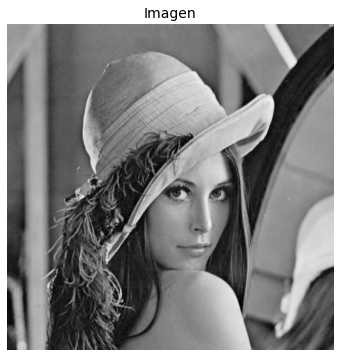

In [3]:
#@title Ingrese imagen desde su equipo: { run: "auto", vertical-output: true }
uploaded = files.upload()

for fn in uploaded.keys():
  name=fn

#Leo la imagen
img = io.imread(name)
if img.ndim <= 2:
  image = img/255
else:
  image_yiq = rgb_to_yiq(img) #pasar la imagen a espacio yiq
  image = image_yiq[:,:,0] #utilizar el canal de la luminancia

plot_image(image,"Imagen")

La proporcion de pixeles blancos en la imagen es: 50.0 %
La proporcion de pixeles negros en la imagen es 50.0 %


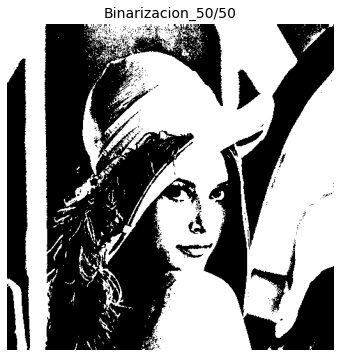

In [6]:
#@title Seleccione el metodo de Binarizacion a aplicar: { run: "auto", vertical-output: true }
Metodo_Binarizacion = 'Binarizacion_50/50' #@param ["Binarizacion_50/50", "Binarizacion_Dist_Min", "Binarizacion_Otsu"]

if Metodo_Binarizacion == "Binarizacion_50/50":
  image_bin = binarizacion(image)
  #Calculo frecuencias 
  width,height = image_bin.shape
  negro,blanco = proporcion(image_bin)
  frec_negro = negro/(width*height)*100
  frec_blanco = blanco/(width*height)*100
  print('La proporcion de pixeles blancos en la imagen es:',round(frec_blanco,1),'%')
  print('La proporcion de pixeles negros en la imagen es',round(frec_negro,1),'%')
elif Metodo_Binarizacion == "Binarizacion_Dist_Min":
  bright_mode, dark_mode = two_mode(image)
  print('El valor  de la moda clara es:',bright_mode)
  print('El valor de la moda oscura es:',dark_mode)
  image_bin=dist_min(image,bright_mode,dark_mode)
elif Metodo_Binarizacion == "Binarizacion_Otsu":
  image_bin=otsu(image)

plot_image(image_bin,Metodo_Binarizacion)


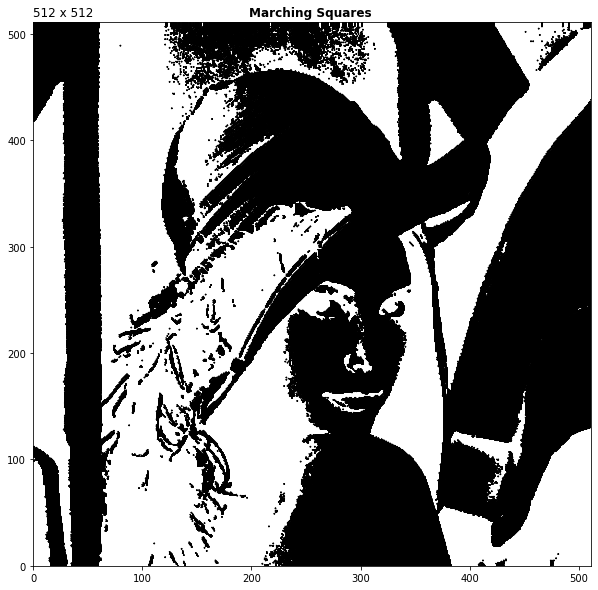

In [7]:
#@title Seleccione un metodo para Detectar Bordes: { run: "auto", vertical-output: true }
Detector_borde_por = 'Marching_Square' #@param ["Laplaciano_v4","Laplaciano_v8","Borde_interno", "Borde_externo", "Marching_Square"]

if Detector_borde_por == "Laplaciano_v4":
  image_conv = _convolution(image,kernel_laplaciano_v4)
  plot_image(image_conv, Detector_borde_por)
elif Detector_borde_por == "Laplaciano_v8":
  image_conv = _convolution(image,kernel_laplaciano_v8)
  plot_image(image_conv, Detector_borde_por)
elif Detector_borde_por == "Borde_interno":
  processed_image = image - erosion(image)
  plot_image(processed_image, Detector_borde_por)
elif Detector_borde_por == "Borde_externo":
  processed_image = dilatacion(image) - image
  plot_image(processed_image, Detector_borde_por)
elif Detector_borde_por == "Marching_Square":
  img_bin=binarizacion(image)
  ms = MarchingSquares(img_bin.tolist())
  #ms.plot_grid()
  #ms.plot_edges()
  #ms.plot_polygons()
  ms.plot_polygons(show_grid=False, edge_color='black',fill_color='black',fig_size=(10,10))


